# Coursework 2: Generative Models

#

#### Working environment:

We recommend that you use Google Colaboratory in order to train the required networks.



### Setting up working environment

You will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction


For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).


# Part 1 - Variational Autoencoder



In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import manifold
from tqdm import tqdm_notebook
import time
from matplotlib import offsetbox


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 50
learning_rate  =  1e-4
batch_size = 64
### Choose a value for the size of the latent space
latent_dim = 64

###

# Define here the any extra hyperparameters you used.

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x



## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Model Definition

In [0]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv_encode = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=128, out_channels=latent_dim*2, kernel_size=3,stride = 1, padding = 1),
            nn.BatchNorm2d(latent_dim*2),
            nn.Tanh(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )

        self.linear_encode = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Dropout(0.2),
            nn.Linear(128, latent_dim*2),
            nn.Tanh()
            
        )

        self.linear_decode = nn.Sequential(
            
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 784),
            nn.Sigmoid()
        )

        self.linear_encode_mu = nn.Sequential(
            nn.Linear(latent_dim*2, 128),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(128, latent_dim)
        )

        self.linear_encode_logvar = nn.Sequential(
            nn.Linear(latent_dim*2, 128),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(128, latent_dim),
            #nn.Tanh()
        )

        self.linear_encode_simple = nn.Sequential(
            nn.Linear(784, latent_dim*2),
            nn.ReLU()
        )

        self.linear_decode_simple = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400,784),
            nn.Sigmoid()
        )


        
        
    def encode(self, x):

        self.img_shape = x.shape
        
        x = x.view(self.img_shape[0], -1)
        #mu_logvar = self.linear_encode(x) 
        mu_logvar = self.linear_encode_simple(x)
        
        '''
        mu_logvar = self.conv_encode(x)
        mu_logvar = mu_logvar.view(self.img_shape[0], -1)
        '''

        mu = self.linear_encode_mu(mu_logvar)
        logvar = self.linear_encode_logvar(mu_logvar)
        
        return mu, logvar
 
    
    def reparametrize(self, mu, logvar):

        z = mu+torch.exp(0.5*logvar)*torch.randn_like(mu)
        return z
 

        
    def decode(self, z):

        #out = self.linear_decode(z)
        out = self.linear_decode_simple(z)
        out = torch.clamp(out, 0, 1)
        out = out.reshape(z.shape[0], self.img_shape[1], self.img_shape[2],self.img_shape[3])
        return out
 

    
    def forward(self, x):

        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar


    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 1889136
VAE(
  (conv_encode): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout2d(p=0.2, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1

## Training loop

In [0]:


def loss_function_VAE(x, y, mu, logvar, beta = 1):
##
  shape = x.shape
  x = x.view(shape[0], -1)
  y = y.view(shape[0], -1)
  expectation = -F.binary_cross_entropy(y, x, reduction='sum')/shape[0]
  #-F.mse_loss(y,x) #torch.sum(torch.sum(x-y, dim = 1)**2)/shape[0]#-F.binary_cross_entropy(y, x, reduction='sum')/shape[0]
  KL = 0.5*torch.sum(1+logvar-mu**2-torch.exp(logvar), dim = 1).sum()/shape[0]
  loss = expectation+beta*KL
  loss = -loss
  return loss, -KL, expectation

loss_list = []
KL_list = []
expectation_list = []
loss_test = []
KL_test = []
expectation_test = []
for epoch in tqdm_notebook(range(num_epochs)):     

  model.train()
  train_loss = 0
  train_KL = 0
  train_expectation = 0
  for batch_idx, data in enumerate(loader_train):
    img, _ = data
    img = img.to(device)
    optimizer.zero_grad()
    # forward
    out, mu, logvar = model(img)

    loss, KL, expectation = loss_function_VAE(img, out, mu, logvar, beta = 0.5)
    # backward
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
    train_KL += KL.item()
    train_expectation += expectation.item()
   
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(loader_train.dataset)))
  
  loss_list.append(train_loss/len(loader_train.dataset))
  KL_list.append(train_KL/len(loader_train.dataset))
  expectation_list.append(train_expectation/len(loader_train.dataset))
  
  #test
  model.eval()
  test_loss = 0
  test_KL = 0
  test_expectation = 0
  with torch.no_grad():
    for batch_idx, data in enumerate(loader_test):
      img, _ = data
      img = img.to(device)
      out, mu, logvar = model(img)
      loss, KL, expectation = loss_function_VAE(img, out, mu, logvar, beta = 0.5)
      test_loss += loss.item()
      test_KL += KL.item()
      test_expectation += expectation.item()
    loss_test.append(test_loss/len(loader_test.dataset))
    KL_test.append(test_KL/len(loader_test.dataset))
    expectation_test.append(test_expectation/len(loader_test.dataset))

# save the model 

torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')



epoch [1/50], loss:3.5983
epoch [2/50], loss:2.6162
epoch [3/50], loss:2.3302
epoch [4/50], loss:2.1846
epoch [5/50], loss:2.0930
epoch [6/50], loss:2.0173
epoch [7/50], loss:1.9498
epoch [8/50], loss:1.8962
epoch [9/50], loss:1.8506
epoch [10/50], loss:1.8121
epoch [11/50], loss:1.7786
epoch [12/50], loss:1.7489
epoch [13/50], loss:1.7225
epoch [14/50], loss:1.6992
epoch [15/50], loss:1.6770
epoch [16/50], loss:1.6580
epoch [17/50], loss:1.6412
epoch [18/50], loss:1.6248
epoch [19/50], loss:1.6096
epoch [20/50], loss:1.5957
epoch [21/50], loss:1.5828
epoch [22/50], loss:1.5708
epoch [23/50], loss:1.5594
epoch [24/50], loss:1.5486
epoch [25/50], loss:1.5392
epoch [26/50], loss:1.5305
epoch [27/50], loss:1.5225
epoch [28/50], loss:1.5146
epoch [29/50], loss:1.5076
epoch [30/50], loss:1.5012
epoch [31/50], loss:1.4954
epoch [32/50], loss:1.4897
epoch [33/50], loss:1.4839
epoch [34/50], loss:1.4792
epoch [35/50], loss:1.4745
epoch [36/50], loss:1.4707
epoch [37/50], loss:1.4669
epoch [38/

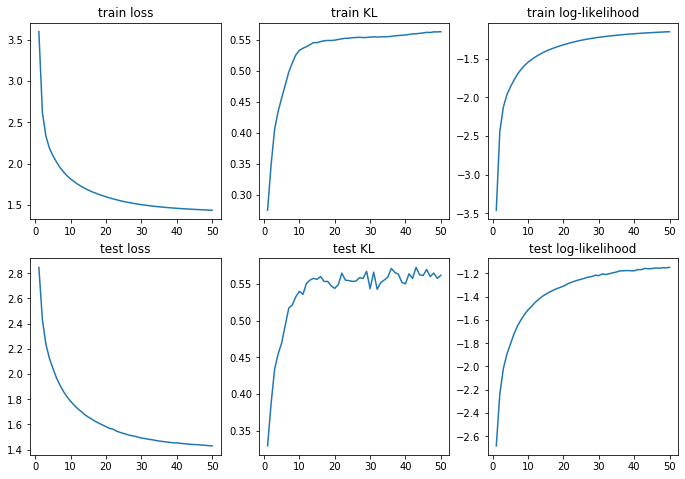

In [0]:

plt.subplots_adjust(left=0.0,bottom=0.0,top=1.5,right=1.5)
fig1 = plt.subplot(2,3,1)
fig1.plot(np.arange(1,num_epochs+1,1), np.array(loss_list))
fig1.set_title('train loss')
fig2 = plt.subplot(2,3,2)
fig2.plot(np.arange(1,num_epochs+1,1), np.array(KL_list))
fig2.set_title('train KL')
fig3 = plt.subplot(2,3,3)
fig3.plot(np.arange(1,num_epochs+1,1), np.array(expectation_list))
fig3.set_title('train log-likelihood')
fig4 = plt.subplot(2,3,4)
fig4.plot(np.arange(1,num_epochs+1,1), np.array(loss_test))
fig4.set_title('test loss')
fig5 = plt.subplot(2,3,5)
fig5.plot(np.arange(1,num_epochs+1,1), np.array(KL_test))
fig5.set_title('test KL')
fig6 = plt.subplot(2,3,6)
fig6.plot(np.arange(1,num_epochs+1,1), np.array(expectation_test))
fig6.set_title('test log-likelihood')
plt.show()

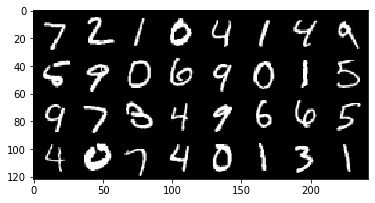

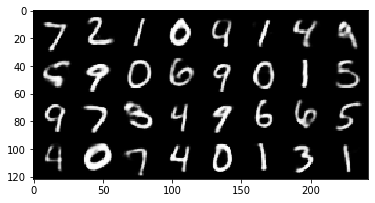

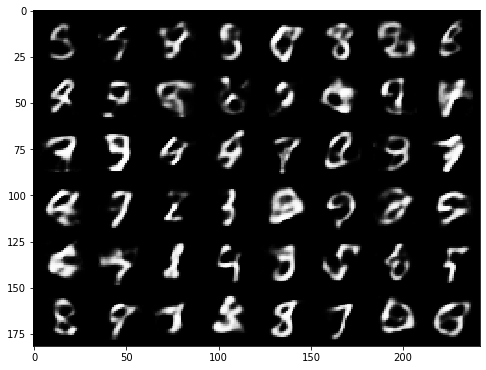

In [0]:

# load the model
model = VAE()
model = model.to(device)
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    

    fixed_input = fixed_input.to(device)
    recon_batch,_,_ = model(fixed_input)

    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 48
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():

    samples = model.decode(z)
 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



In [0]:
#code refer to sklearn example
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)

    for i in range(X.shape[0]):
        
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                  color=plt.cm.Set1(y[i] / 10.),
                  fontdict={'weight': 'bold', 'size': 10}, label = str(y[i]))
        '''
        plt.scatter(X[i, 0], X[i, 1], color = plt.cm.Set1(y[i] / 10.), label = str(y[i]))
        '''
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.legend()
    fig.set_size_inches(16.5, 8.5)
    #fig.set_size_inches(4, 4)
    plt.savefig('./CW_VAE/MNIST/t-SNE.jpg')

In [0]:

model = VAE()
model = model.to(device)
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
model.eval()
mu_list = []
logvar_list = []
digit_class_list = []

with torch.no_grad():
  for batch_idx, data in enumerate(loader_test):
      img, digit_class = data
      img = img.to(device)
      mu, logvar = model.encode(img)
      mu_list.append(mu.detach().cpu())
      logvar_list.append(logvar.detach().cpu())
      digit_class_list.append(digit_class)

mu_list = np.concatenate(mu_list, axis = 0)
logvar_list = np.concatenate(logvar_list, axis = 0)
digit_class_list = np.concatenate(digit_class_list, axis = 0)
latent = np.column_stack((mu_list, logvar_list))

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(latent)

No handles with labels found to put in legend.


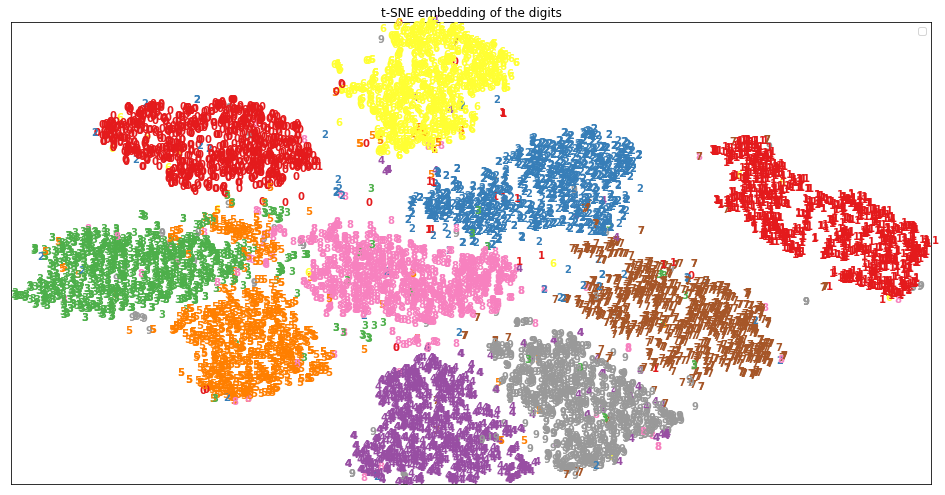

In [0]:
plot_embedding(X_tsne,digit_class_list,
               "t-SNE embedding of the digits" )

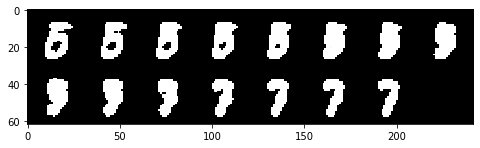

In [0]:

def linear_interpolation(mu1, logvar1, mu2, logvar2, size = 15):
  mu1 = mu1.view(-1).detach().cpu()
  mu2 = mu2.view(-1).detach().cpu()
  logvar1 = logvar1.view(-1).detach().cpu()
  logvar2 = logvar2.view(-1).detach().cpu()
  new_matrix = np.ones((size, latent_dim*2))
  for i in range(latent_dim):
    new_matrix[:,i] = np.linspace(mu1[i], mu2[i], size)
    new_matrix[:,i+latent_dim] = np.linspace(logvar1[i], logvar2[i], size)
  return torch.FloatTensor(new_matrix)

data1 = test_dat.data[45] # 3:453 5:45 7:5234
data2 = test_dat.data[5234]
data1 = data1.reshape(1,1,28,28).float()
data2 = data2.reshape(1,1,28,28).float()

model = VAE()
model = model.to(device)
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
model.eval()
with torch.no_grad():
  data1 = data1.to(device)
  data2 = data2.to(device)
  mu1, logvar1 = model.encode(data1)
  mu2, logvar2 = model.encode(data2)
  interpolation = linear_interpolation(mu1, logvar1, mu2, logvar2)[:, :latent_dim].to(device)
  samples = model.decode(interpolation)
  samples = samples.cpu()
  samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                          range=None, scale_each=False, pad_value=0)
  plt.figure(figsize = (8,8))
  show(samples)

## Part 2 - Deep Convolutional GAN

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [0]:
batch_size = 64  # change that
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.Resize(64),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar10_test[0][0].shape

torch.Size([3, 64, 64])

### Hyper-parameter selection

In [0]:

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 25 #40 50 60 80 100
learning_rate  = 2e-4 #1e-3 1e-4
latent_vector_size = 100 #32 64 128
###

# Define here other hyperparameters that you used.

In [0]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        '''
        self.conv_decode = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, 1024, 4, stride=2, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, 5, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 5, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 3, 4, stride=1, padding=0),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )
        '''
        self.conv_decode = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),


            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
 

    def decode(self, z):

        shape = z.shape
        z = z.view(shape[0], -1, 1, 1)
        x = self.conv_decode(z)
 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        
        self.conv_encode = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
 
        
    def discriminator(self, x):

        out = self.conv_encode(x)
 
        
        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3576704
Generator(
  (conv_decode): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
train_losses_G = []
train_losses_D = []

for epoch in tqdm_notebook(range(num_epochs)):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()
        '''
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        '''
    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

### Generator samples

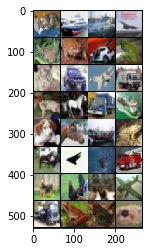

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

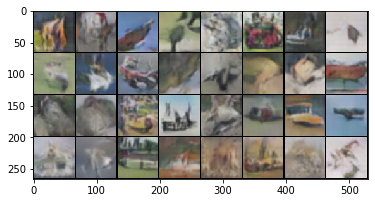

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

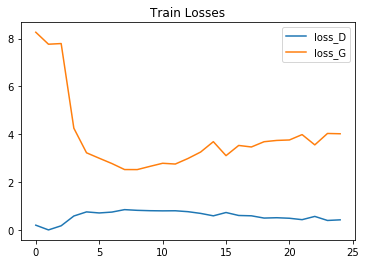

In [0]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()